# BERT Fine-Tuning

## 单句分类

In [1]:
import transformers
import wget
import os
import zipfile
import torch
from torch.utils.data import TensorDataset

### 加载数据集

使用CoLA数据集进行单句分类

下载&解压

In [2]:
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'
if not os.path.exists('./cola_public_1.1.zip'):
    print('Downloading dataset...')
    wget.download(url, os.path.join('./cola_public_1.1.zip'))
    print('Extracting dataset...')
    

In [3]:
if not os.path.exists('./cola_public/'):
    f = zipfile.ZipFile('./cola_public_1.1.zip', 'r')
    for file in f.namelist():
        f.extractall('./cola_public')
    f.close()

In [4]:
import pandas as pd
df = pd.read_csv('cola_public/cola_public/raw/in_domain_train.tsv', delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.sample(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
6657,m_02,1,NaN,Grandma is coming here tomorrow.
3325,l-93,0,*,I had to bulge the bag with groceries.
7919,ad03,1,NaN,Anson became happy
3771,ks08,1,NaN,Michelle became an architect.
7837,ad03,1,NaN,That Plato loved Aster deeply was obvious.
4365,ks08,0,*,We expect the dentist to examine ourselves.
1991,r-67,1,NaN,That anybody ever left at all is not certain.
4794,ks08,1,NaN,John inquired which book he should read.
2230,l-93,1,NaN,This oven cooks well.
6681,m_02,1,NaN,Did Frank buy Jane the piano?


label=0: 语法上不可接受

In [5]:
df.loc[df.label == 0].sample(10)[['sentence', 'label']]

,sentence,label
7977,Julie maintained if the barman was sober.,0
4686,He is looked generally on as selfish.,0
4155,Two drops sanitize anything in your house.,0
7979,Julie became a fond.,0
1306,"Tom picked, and I washed some turnips, and Suz...",0
6006,Calvin not will eat the beef waffles.,0
4805,Kim asked me that the monkeys are very fond of...,0
400,How many people do you wonder whether I consid...,0
2408,Those new bricks constructed a house.,0
7898,I intoned fruit,0


In [6]:
sentences = df.sentence.values
labels = df.label.values

### 分词 & 格式化输入层

将文本通过BERT内部提供的词汇表进行分词

In [7]:
from transformers import BertTokenizer
# 加载 BERT 分词器
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('./local_bert_base_uncased/', do_lower_case=True)


Loading BERT tokenizer...


In [8]:
# 输出原始句子
print(' Original: ', sentences[0])

# 将分词后的内容输出
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# 将每个词映射到词典下标
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))



 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


In [9]:
max_len = 0
for sentence in sentences:
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
print('Max length: ', max_len)

Max length:  47


In [10]:
input_ids = []
attention_mask = []

for sentence in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sentence,                      # 输入文本
                        add_special_tokens = True, # 添加 '[CLS]' 和 '[SEP]'
                        max_length = 64,           # 填充 & 截断长度
                        pad_to_max_length = True,
                        return_attention_mask = True,   # 返回 attn. masks.
                        return_tensors = 'pt',     # 返回 pytorch tensors 格式的数据
                   )
    # 编码后文本和mask
    input_ids.append(encoded_dict['input_ids'])
    attention_mask.append(encoded_dict['attention_mask'])
input_ids = torch.cat(input_ids, dim = 0)
attention_mask = torch.cat(attention_mask, dim = 0)
labels = torch.tensor(labels)

# 输出第 1 行文本的原始和编码后的信息
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
D:\Anaconda\envs\dsxAI\lib\site-packages\transformers\tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [11]:
from torch.utils.data import TensorDataset, random_split
dataset = TensorDataset(input_ids, attention_mask, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,695 training samples
  856 validation samples


In [12]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)
validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size)

### 训练

In [13]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
model = BertForSequenceClassification.from_pretrained('./local_bert_base_uncased/', num_labels=2, output_attentions = False, output_hidden_states = False)
model.cuda()

# 将所有模型参数转换为一个列表
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


D:\Anaconda\envs\dsxAI\lib\site-packages\transformers\utils\generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
D:\Anaconda\envs\dsxAI\lib\site-packages\transformers\modeling_utils.py:488: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. 

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [14]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

D:\Anaconda\envs\dsxAI\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
from transformers import get_linear_schedule_with_warmup

epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


In [16]:
import numpy as np
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [17]:
import time
import datetime
def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [22]:
import random
import numpy as np

# 以下训练代码是基于 `run_glue.py` 脚本:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# 设定随机种子值，以确保输出是确定的
seed_val = 42


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 存储训练和评估的 loss、准确率、训练时长等统计指标, 
training_stats = []

# 统计整个训练时长
total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 统计单次 epoch 的训练时间
    t0 = time.time()

    # 重置每次 epoch 的训练总 loss
    total_train_loss = 0

    # 将模型设置为训练模式。这里并不是调用训练接口的意思
    # dropout、batchnorm 层在训练和测试模式下的表现是不同的 (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # 训练集小批量迭代
    for step, batch in enumerate(train_dataloader):

        # 每经过40次迭代，就输出进度信息
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 准备输入数据，并将其拷贝到 gpu 中
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 每次计算梯度前，都需要将梯度清 0，因为 pytorch 的梯度是累加的
        model.zero_grad()        

        # 前向传播
        # 文档参见: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # 该函数会根据不同的参数，会返回不同的值。 本例中, 会返回 loss 和 logits -- 模型的预测结果

        # 前向传播
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        # 提取 loss 和 logits
        loss = outputs.loss
        logits = outputs.logits
        

        # 累加 loss
        total_train_loss += loss.item()

        # 反向传播
        loss.backward()

        # 梯度裁剪，避免出现梯度爆炸情况
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 更新参数
        optimizer.step()

        # 更新学习率
        scheduler.step()

    # 平均训练误差
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # 单次 epoch 的训练时长
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # 完成一次 epoch 训练后，就对该模型的性能进行验证

    print("")
    print("Running Validation...")

    t0 = time.time()

    # 设置模型为评估模式
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # 将输入数据加载到 gpu 中
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # 评估的时候不需要更新参数、计算梯度
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        # 提取 loss 和 logits
        loss = outputs.loss
        logits = outputs.logits
        # 累加 loss
        total_eval_loss += loss.item()

        # 将预测结果和 labels 加载到 cpu 中计算
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # 计算准确率
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # 打印本次 epoch 的准确率
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # 统计本次 epoch 的 loss
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # 统计本次评估的时长
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # 记录本次 epoch 的所有统计信息
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:13.
  Batch    80  of    241.    Elapsed: 0:00:25.
  Batch   120  of    241.    Elapsed: 0:00:38.
  Batch   160  of    241.    Elapsed: 0:00:51.
  Batch   200  of    241.    Elapsed: 0:01:03.
  Batch   240  of    241.    Elapsed: 0:01:16.

  Average training loss: 0.20
  Training epcoh took: 0:01:16

Running Validation...
  Accuracy: 0.82
  Validation Loss: 0.55
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:12.
  Batch    80  of    241.    Elapsed: 0:00:25.
  Batch   120  of    241.    Elapsed: 0:00:38.
  Batch   160  of    241.    Elapsed: 0:00:50.
  Batch   200  of    241.    Elapsed: 0:01:03.
  Batch   240  of    241.    Elapsed: 0:01:15.

  Average training loss: 0.21
  Training epcoh took: 0:01:15

Running Validation...
  Accuracy: 0.83
  Validation Loss: 0.52
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...
 

In [23]:
import pandas as pd

# 保留 2 位小数
pd.set_option('precision', 2)

# 加载训练统计到 DataFrame 中
df_stats = pd.DataFrame(data=training_stats)

# 使用 epoch 值作为每行的索引
df_stats = df_stats.set_index('epoch')

# 展示表格数据
df_stats


,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.20,0.55,0.82,0:01:16,0:00:02
2,0.21,0.52,0.83,0:01:15,0:00:02
3,0.14,0.58,0.83,0:01:13,0:00:02
4,0.12,0.58,0.83,0:01:13,0:00:03


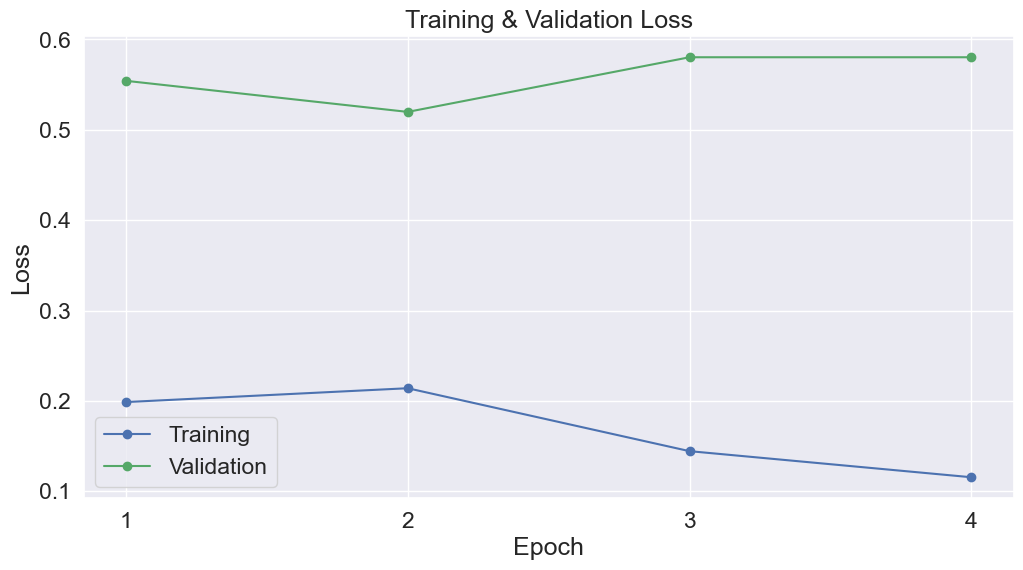

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# 绘图风格设置
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# 绘制学习曲线
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()


In [28]:
import pandas as pd

# 加载数据集
df = pd.read_csv("./cola_public/cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# 打印数据集大小
print('Number of test sentences: {:,}\n'.format(df.shape[0]))
# 将数据集转换为列表
sentences = df.sentence.values
labels = df.label.values

# 分词、填充或截断
input_ids = []
attention_masks = []
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, 
                        max_length = 64,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

batch_size = 32  

# 准备好数据集
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


Number of test sentences: 516



D:\Anaconda\envs\dsxAI\lib\site-packages\transformers\tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [29]:
# 预测测试集

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
# 依然是评估模式
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# 预测
for batch in prediction_dataloader:
  # 将数据加载到 gpu 中
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  
  # 不需要计算梯度
  with torch.no_grad():
      # 前向传播，获取预测结果
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # 将结果加载到 cpu 中
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # 存储预测结果和 labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')


Predicting labels for 516 test sentences...
    DONE.


In [30]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))



Positive samples: 354 of 516 (68.60%)


In [31]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# 计算每个 batch 的 MCC
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # 计算该 batch 的 MCC  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)


Calculating Matthews Corr. Coef. for each batch...


C:\Users\52460\AppData\Local\Temp\ipykernel_46124\3983116212.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)


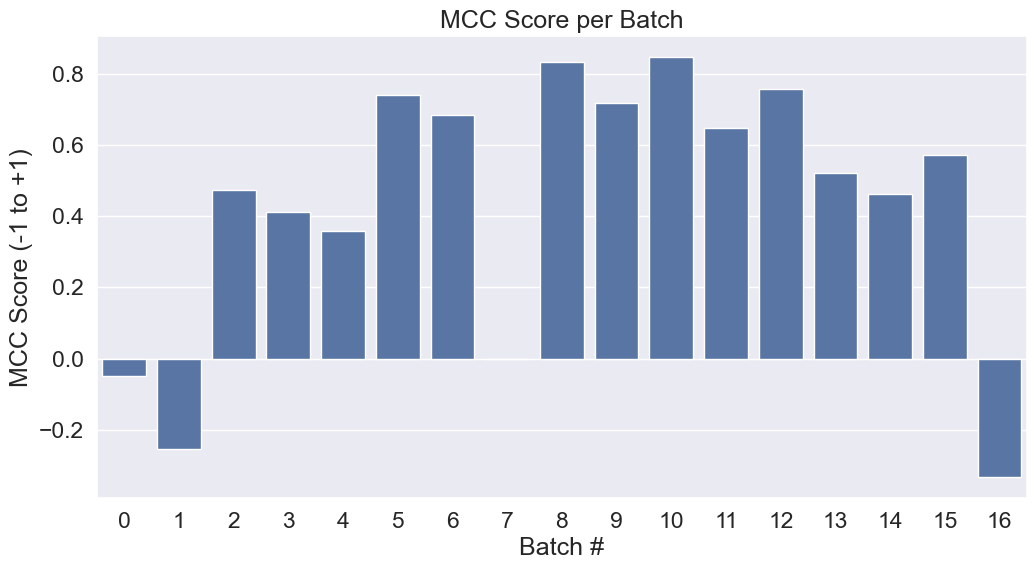

In [32]:
# 创建柱状图来显示每个 batch 的 MCC 分数
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()


In [33]:
# 合并所有 batch 的预测结果
flat_predictions = np.concatenate(predictions, axis=0)

# 取每个样本的最大值作为预测值
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# 合并所有的 labels
flat_true_labels = np.concatenate(true_labels, axis=0)

# 计算 MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)



Total MCC: 0.519
